### Load Modules

In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
!pip install opencv-python

### Prepare/collect data

In [35]:
import os
import cv2
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator


data_dir = 'brain_tumor/Training/'
classes = {'no_disease': 0, 'pituitary_tumor': 1, 'moderate_alzheimer': 2}


X = []
Y = []

for cls in classes:
    cls_path = os.path.join(data_dir, cls)
    
    for img_file in os.listdir(cls_path):
        img = cv2.imread(os.path.join(cls_path, img_file), 0)
        img = cv2.resize(img, (200, 200))
        X.append(img)
        Y.append(classes[cls])

X = np.array(X)
Y = np.array(Y)
X = X.reshape(len(X), -1)

# Initialize the ImageDataGenerator for augmentation
datagen = ImageDataGenerator(
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    fill_mode='nearest'
)

# Augment the data for class 2
X_augmented = []
Y_augmented = []
for i in range(X.shape[0]):
    img = X[i].reshape((1, 200, 200, 1))  # Reshape the image for augmentation
    y = Y[i]
    # Check if the image belongs to class 2
    if y == 2:
        # Generate augmented images
        augmented_imgs = datagen.flow(img, batch_size=1)
        for _ in range(3):  # Augment each image 5 times
            augmented_img = next(augmented_imgs)[0]
            X_augmented.append(augmented_img.reshape((200, 200)))  # Append augmented image to the list
            Y_augmented.append(y)  # Append corresponding label
    else:
        # Add original images from classes 0 and 1
        X_augmented.append(X[i].reshape((200, 200)))
        Y_augmented.append(y)

# Convert lists to numpy arrays
X_augmented = np.array(X_augmented)
Y_augmented = np.array(Y_augmented)

# Check the shape of augmented data
print("Shape of augmented data:", X_augmented.shape, Y_augmented.shape)


Shape of augmented data: (4279, 200, 200) (4279,)


In [36]:
import pandas as pd
pd.Series(Y_augmented).value_counts()

2    1485
0    1397
1    1397
dtype: int64

In [37]:
X=X_augmented
Y=Y_augmented

In [38]:
X.shape

(4279, 200, 200)

### Visualize data

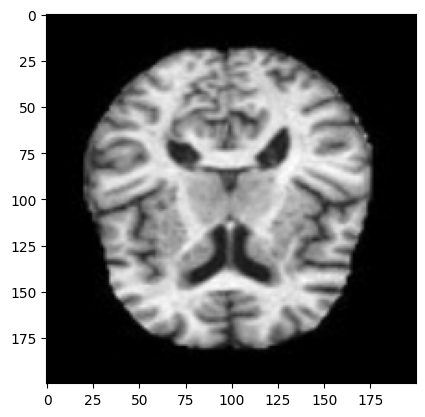

In [39]:
plt.imshow(X[0], cmap='gray')

### Prepare data

In [40]:
X_updated = X.reshape(len(X), -1)
X_updated.shape

(4279, 40000)

### Split Data

In [41]:
xtrain, xtest, ytrain, ytest = train_test_split(X_updated, Y, random_state=10,
                                               test_size=.20)

In [42]:
xtrain.shape, xtest.shape

((3423, 40000), (856, 40000))

In [43]:
print(len(xtrain))
print(len(xtest))

3423
856


In [44]:
pd.Series(ytrain).value_counts()

2    1190
1    1128
0    1105
dtype: int64

In [45]:
pd.Series(ytest).value_counts()

2    295
0    292
1    269
dtype: int64

### Feature Scaling

In [46]:
print(xtrain.max(), xtrain.min())
print(xtest.max(), xtest.min())
xtrain = xtrain/255
xtest = xtest/255


print(xtrain.max(), xtrain.min())
print(xtest.max(), xtest.min())


255.0 0.0
255.0 0.0


1.0 0.0
1.0 0.0


In [47]:
len(xtrain)

3423

### Train Model

In [48]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

In [49]:
import warnings
warnings.filterwarnings('ignore')

lg = LogisticRegression()
lg.fit(xtrain, ytrain)

LogisticRegression()

In [50]:
sv = SVC()
sv.fit(xtrain, ytrain)

SVC()

In [51]:
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
dt = DecisionTreeClassifier()
dt.fit(xtrain,ytrain)

DecisionTreeClassifier()

In [52]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
rf = RandomForestClassifier(n_estimators=150,random_state=0)
rf.fit(xtrain,ytrain)

RandomForestClassifier(n_estimators=150, random_state=0)

### Evaluation

In [53]:
print("Training Score:", lg.score(xtrain, ytrain))
print("Testing Score:", lg.score(xtest, ytest))

Training Score: 1.0
Testing Score: 0.9404205607476636


In [54]:
print("Training Score:", sv.score(xtrain, ytrain))
print("Testing Score:", sv.score(xtest, ytest))

Training Score: 0.990651475314052
Testing Score: 0.9672897196261683


In [55]:
print("Training Score:", dt.score(xtrain, ytrain))
print("Testing Score:", dt.score(xtest, ytest))

Training Score: 1.0
Testing Score: 0.9497663551401869


In [56]:
print("Training Score:", rf.score(xtrain, ytrain))
print("Testing Score:", rf.score(xtest, ytest))

Training Score: 1.0
Testing Score: 0.977803738317757


### Prediction

In [57]:
pred = lg.predict(xtest)
confusion_matrix(ytest, pred)

array([[262,  19,  11],
       [  2, 265,   2],
       [ 12,   5, 278]])

In [58]:
pred = sv.predict(xtest)
confusion_matrix(ytest, pred)

array([[267,  22,   3],
       [  0, 267,   2],
       [  1,   0, 294]])

In [59]:
pred = dt.predict(xtest)
confusion_matrix(ytest, pred)

array([[272,  14,   6],
       [  9, 253,   7],
       [  5,   2, 288]])

In [60]:
pred = rf.predict(xtest)
confusion_matrix(ytest, pred)

array([[281,   8,   3],
       [  0, 264,   5],
       [  0,   3, 292]])

In [61]:
misclassified=np.where(ytest!=pred)
misclassified

(array([ 10, 189, 290, 323, 345, 366, 369, 386, 450, 465, 483, 485, 575,
        588, 616, 643, 662, 700, 730]),)

In [62]:
print("Total Misclassified Samples: ",len(misclassified[0]))

Total Misclassified Samples:  19


### TEST MODEL

In [63]:
dec = {0:'No Disease', 1:'Positive Tumor', 2:'Positive Alzheimer'}

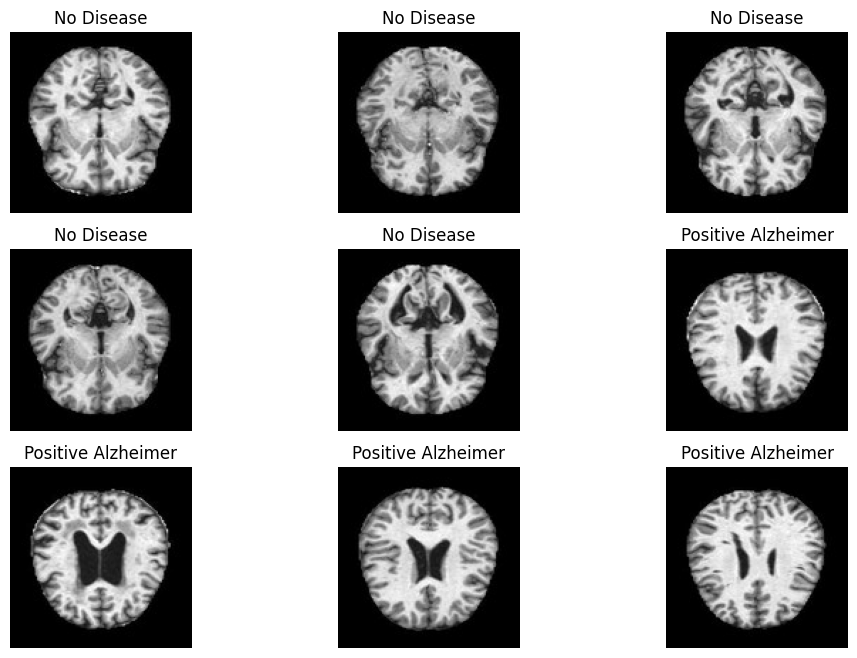

In [64]:
plt.figure(figsize=(12,8))
p = os.listdir('brain_tumor/Testing/')
c=1
for i in os.listdir('brain_tumor/Testing/no_disease/')[:9]:
    plt.subplot(3,3,c)
    
    img = cv2.imread('brain_tumor/Testing/no_disease/'+i,0)
    img1 = cv2.resize(img, (200,200))
    img1 = img1.reshape(1,-1)/255
    p = sv.predict(img1)
    plt.title(dec[p[0]])
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    c+=1
   


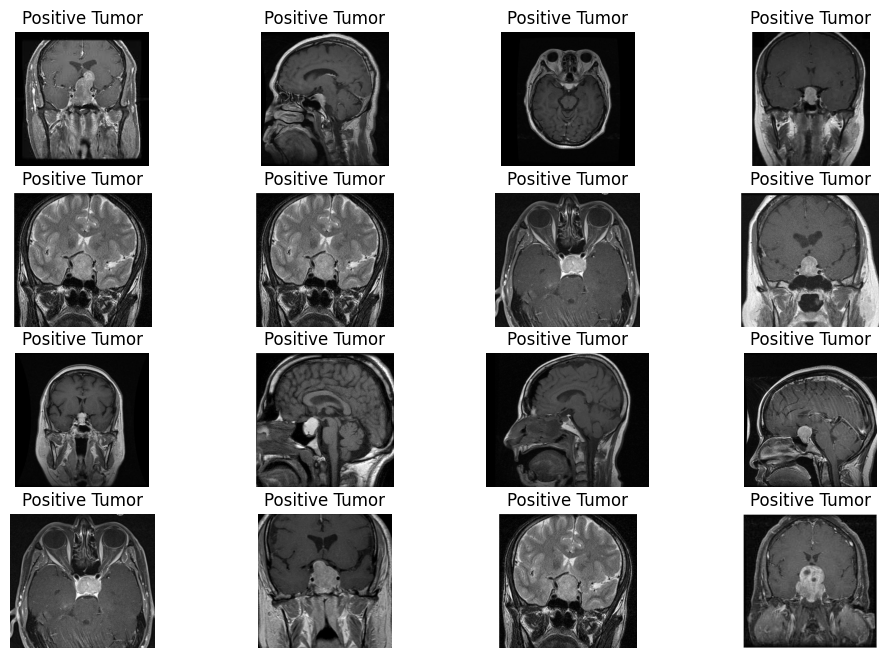

In [65]:
plt.figure(figsize=(12,8))
p = os.listdir('brain_tumor/Testing/')
c=1
for i in os.listdir('brain_tumor/Testing/pituitary_tumor/')[:16]:
    plt.subplot(4,4,c)
    
    img = cv2.imread('brain_tumor/Testing/pituitary_tumor/'+i,0)
    img1 = cv2.resize(img, (200,200))
    img1 = img1.reshape(1,-1)/255
    p = sv.predict(img1)
    plt.title(dec[p[0]])
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    c+=1

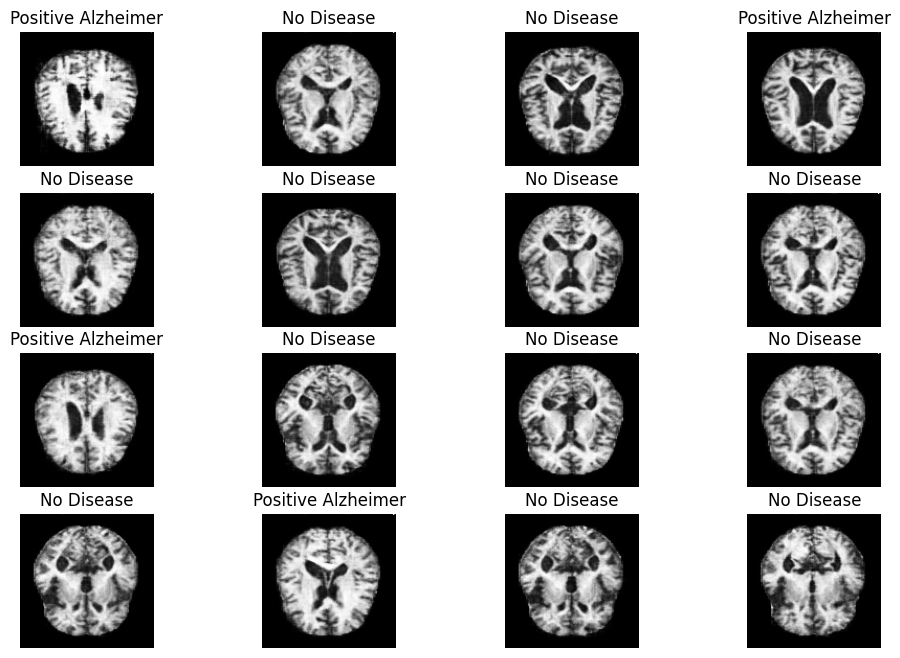

In [66]:
plt.figure(figsize=(12,8))
p = os.listdir('brain_tumor/Testing/')
c=1
for i in os.listdir('brain_tumor/Testing/moderate_test/')[:16]:
    plt.subplot(4,4,c)
    
    img = cv2.imread('brain_tumor/Testing/moderate_test/'+i,0)
    img1 = cv2.resize(img, (200,200))
    img1 = img1.reshape(1,-1)/255
    p = sv.predict(img1)
    plt.title(dec[p[0]])
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    c+=1